In [88]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

In [89]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

In [146]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import seaborn as sns
import math
from tqdm.notebook import tqdm
from typing import List, Tuple
from torch.utils.tensorboard import SummaryWriter
import itertools
import random

@dataclass
class Args:
    random_seed = None
    # torch
    batch_size = 10
    epochs = 100
    layers = 10
    layer_size = 16
    train_size = 0.8
    wandb = False
    # graph
    graph_size = 800
    graph_shape = 'disc'
    rg_radius = 0.05

args = Args()

In [147]:
import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


In [148]:
NodePosition = Tuple[float, float]
NodePositions = List[NodePosition]
NodeIndexPairs = List[Tuple[int, int]]

def gen_nodes(size: int, shape: str = "disc") -> NodePositions:
    if shape == 'disc':
        return __gen_nodes_disc(size)
    else:
        raise f'unsupported node shape: {shape}'


def __gen_nodes_disc(amount: int) -> NodePositions:
    points = []
    with tqdm(total=amount, desc="generating random-uniform nodes on disc") as pbar:
        while len(points) < amount:
            p = (random.uniform(0, 1), random.uniform(0, 1))
            d = (p[0] - 0.5, p[1] - 0.5)
            if math.sqrt(d[0] * d[0] + d[1] * d[1]) > 0.5:
                continue
            points.append(p)
            pbar.update(1)
    return points


def get_node_pairs(n_nodes: int) -> NodeIndexPairs:
    return [
        (i0, i1)
        for i0 in range(n_nodes)
        for i1 in range(i0 + 1, n_nodes)
    ]

# generates an edge with a specified distance on a unit disc
# the distance has to be in (0, 1).
def gen_disc_edge(d: float) -> [float, float, float, float]:
    # loop with p in case p is badly chosen
    while True:
        px, py = random.uniform(0, 1), random.uniform(0, 1)
        v = np.random.random(2) # random direction
        vd = (v / np.linalg.norm(v)) * d
        [qx, qy] = [px, py] + vd
        if math.dist([px, py], [0.5, 0.5]) <= 0.5 and math.dist([qx, qy], [0.5, 0.5]) <= 0.5:
            return [px, py, qx, qy]


# https://stackoverflow.com/a/36460020/10619052
def list_to_dict(items: list) -> dict:
    return {v: k for v, k in enumerate(items)}

In [149]:
# Define graph builder
class RandomGeometricGraphBuilder:
    def __init__(self):
        # generate graph
        self.nodes = gen_nodes(args.graph_size, args.graph_shape)
        self.n_nodes = len(self.nodes)
        self.graph = nx.random_geometric_graph(
            self.n_nodes,
            args.rg_radius,
            pos=list_to_dict(self.nodes)
        )
        self.node_index_pairs = get_node_pairs(self.n_nodes)
        self.adjacency_matrix = nx.adjacency_matrix(self.graph)

In [150]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [155]:
# Define evaluator
class EmbeddingEvaluator:
    def __init__(self, nodes: NodePositions, adjacency_matrix):
        self.nodes = nodes
        self.adjacency_matrix = adjacency_matrix
        # pre calculations
        self.n_nodes = len(nodes)
        self.node_index_pairs = list(itertools.combinations(range(self.n_nodes), 2))
        self.node_degrees = self.adjacency_matrix.sum(axis=0)
        # complete dataset
        ds_values = [ e.flatten().tolist() for e in np.array(self.nodes)[self.node_index_pairs]]
        ds_labels = [ int(self.adjacency_matrix[s]) for s in self.node_index_pairs ]
        self.ds_values = torch.FloatTensor(ds_values).to(device)
        self.ds_labels = torch.FloatTensor(ds_labels).to(device)
        self.dataset = TensorDataset(self.ds_values, self.ds_labels)
        self.dataloader = DataLoader(self.dataset, batch_size=args.batch_size, shuffle=True)
        # generate net
        self.net = NeuralNetwork().to(device)
        # tensorboard
        self.writer = SummaryWriter()

    def train(self, loss_fn, optimizer, print_losses: bool = True):
        losses = []

        self.net.train()
        with tqdm(total=args.epochs, desc="training model...") as pbar:
            for epoch in range(args.epochs):
                pbar.set_description(f"epoch {epoch + 1}")
                epoch_loss_sum = 0

                # sample subgraph (by node degree) and generate dataset
                node_sampler = WeightedRandomSampler(self.node_degrees, 100, replacement=False)
                sampled_nodes = list(node_sampler)
                sampled_node_pairs = list(itertools.combinations(sampled_nodes, 2))
                ds_values = [ e.flatten().tolist() for e in np.array(self.nodes)[sampled_node_pairs]]
                ds_labels = [ int(self.adjacency_matrix[s]) for s in sampled_node_pairs ]

                ds_values = torch.FloatTensor(ds_values).to(device)
                ds_labels = torch.FloatTensor(ds_labels).to(device)
                ds = TensorDataset(ds_values, ds_labels)

                # use custom sampler that keeps labels in balance
                labels_unique, labels_count = np.unique(ds_labels.cpu(), return_counts=True) # independent of train-test split (has both classes)
                labels_weights = [
                    (1 / labels_count[int(l)])
                    for _, l in ds
                ]
                edge_sampler = WeightedRandomSampler(labels_weights, len(labels_weights), replacement=True)
                train_dataloader = DataLoader(ds, batch_size=args.batch_size, sampler=edge_sampler)

                for i_batch, (x_train, y_train) in enumerate(train_dataloader):

                    optimizer.zero_grad()

                    y_pred = self.net(x_train)
                    loss = loss_fn(y_pred, y_train.unsqueeze(1))
                    # TODO calculate acc

                    loss.backward()
                    optimizer.step()

                    epoch_loss_sum += loss.item()

                epoch_loss = epoch_loss_sum / len(train_dataloader)
                losses.append(epoch_loss)
                self.writer.add_scalar('epoch loss', epoch_loss, epoch)

                #if epoch % 10 == 0 or epoch == args.epochs - 1:
                #    self.net.eval()
                #    out = self.net(self.ds_values.to(device)) # TODO use complete graph values
                #    pred = torch.sigmoid(out)
                #    f = self.__print_graph([el.squeeze().tolist() for el in pred])
                #    self.writer.add_figure('predicted graph', f, epoch)
                #    self.net.train()


                # update progress
                pbar.update(1)
                pbar.set_postfix_str(f"last epoch loss: {epoch_loss:>6f}")

        if print_losses:
            plt.plot(np.array(losses))
            plt.show()


    def test(self):
        self.net.eval()
        all_pred_label = []
        all_label = []
        with torch.no_grad():
            test_dataloader = DataLoader(self.dataset, batch_size=args.batch_size)
            for i_batch, (x_test, y_test) in enumerate(test_dataloader):
                y_pred = self.net(x_test)
                pred = torch.sigmoid(y_pred)
                pred_label = torch.round(pred)
                all_pred_label.append(pred_label.cpu().numpy())
                all_label.append(y_test.cpu().numpy())

        all_pred_label = sum([el.squeeze().tolist() for el in all_pred_label], [])
        all_label = sum([el.squeeze().tolist() for el in all_label], [])

        #confusion_matrix(all_label, all_pred_label)
        print(classification_report(all_label, all_pred_label))


    def evaluate(self, print_report: bool = True, print_graph: bool = True):
        self.net.eval()
        with torch.no_grad():
            out = self.net(self.ds_values.to(device))
            pred = torch.sigmoid(out)
            pred_label = torch.round(pred)

            if print_report:
                #? how many wrongly predicted true/false
                print(classification_report(
                    self.ds_labels.cpu().numpy(),
                    pred_label.cpu(),
                    labels=[0, 1]
                ))

            _fig = None
            if print_graph:
                _pred = [el.squeeze().tolist() for el in pred]
                _fig = self.__print_graph(_pred)

            return out, pred, pred_label, _fig


    def __print_graph(self, pred: List[float], save_fig: bool = False):
        fig, ax = plt.subplots(1, 2)
        nodes_dict = list_to_dict(self.nodes)

        # generate embedding graph
        embed_graph = nx.Graph()
        embed_graph.add_nodes_from(range(self.n_nodes))
        sources, targets = evaluator.adjacency_matrix.nonzero()
        edges = zip(sources.tolist(), targets.tolist())
        embed_graph.add_edges_from(edges)

        # print embed graph
        ax[0].set_axis_off()
        ax[0].set_aspect('equal')
        ax[0].set_title("original graph")
        nx.draw_networkx(embed_graph, pos=nodes_dict, ax=ax[0], node_size=5, with_labels=False, labels={})

        # generate predict graph
        colors_filtered = np.array([
            pred[i]
            for i, _ in enumerate(self.node_index_pairs)
            if pred[i] > 0.5
        ])
        colormap = sns.color_palette("flare", as_cmap=True)
        pred_graph = nx.Graph()
        pred_graph.add_nodes_from(range(self.n_nodes))
        pred_graph.add_edges_from([
            pair
            for i, pair in enumerate(self.node_index_pairs)
            if pred[i] > 0.5
        ])

        # print predicted graph
        ax[1].set_axis_off()
        ax[1].set_aspect('equal')
        ax[1].set_title("reconstructed graph")
        nx.draw_networkx(pred_graph, pos=nodes_dict, ax=ax[1], node_size=5, with_labels=False, labels={}, edge_color=colors_filtered, edge_cmap=colormap)

        # add color bar for predictions
        cax = fig.add_axes([ax[1].get_position().x1 + 0.01, ax[1].get_position().y0, 0.02, ax[1].get_position().height])
        fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), cax=cax, label="confidence")

        if save_fig:
            plt.savefig('./filename.png', dpi=300)
        return fig

generating random-uniform nodes on disc:   0%|          | 0/800 [00:00<?, ?it/s]

training model...:   0%|          | 0/100 [00:00<?, ?it/s]

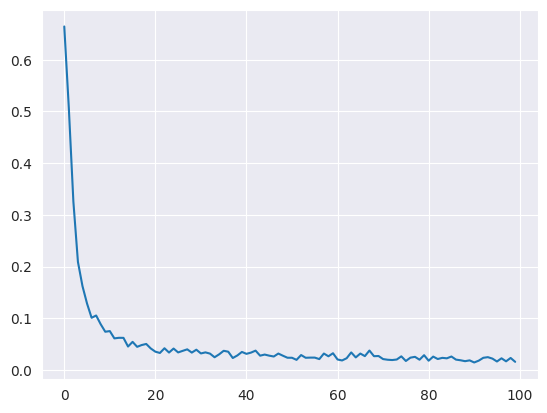

In [156]:
evaluator = None
graph_builder = None

for _ in range(1):
    # build and run evaluator
    graph_builder = RandomGeometricGraphBuilder()
    evaluator = EmbeddingEvaluator(
        graph_builder.nodes,
        graph_builder.adjacency_matrix,
    )

    evaluator.train(
        loss_fn=nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3)
    )

In [157]:
evaluator.test()

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    316489
         1.0       0.54      1.00      0.70      3111

    accuracy                           0.99    319600
   macro avg       0.77      1.00      0.85    319600
weighted avg       1.00      0.99      0.99    319600



              precision    recall  f1-score   support

           0       1.00      0.99      1.00    316489
           1       0.54      1.00      0.70      3111

    accuracy                           0.99    319600
   macro avg       0.77      1.00      0.85    319600
weighted avg       1.00      0.99      0.99    319600



/tmp/ipykernel_13339/1425891674.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


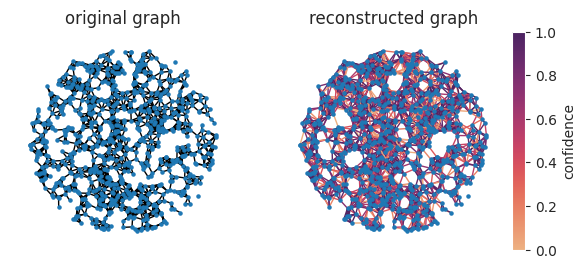

In [158]:
# evaluate embedding
_, eval_pred, eval_pred_label, figure = evaluator.evaluate()
figure.show()

In [ ]:
# print edge distance to prediction

# generate 10x edges per distance
dist_edges = [
    (d, [
        gen_disc_edge(d)
        for _ in range(8)
    ])
    for d in np.arange(0, 1, 0.001)
]

xs = []
ys_mean = []
ys_std = []

evaluator.net.eval()
with torch.no_grad():
    for d, edges in dist_edges:
        out = evaluator.net(torch.FloatTensor(edges).to(device))
        pred = torch.sigmoid(out)
        pred = [el.squeeze().tolist() for el in pred]
        xs.append(d)
        ys_mean.append(np.mean(pred))
        ys_std.append(np.std(pred))

In [ ]:
fig = plt.figure()
plt.scatter(xs, ys_mean)
plt.errorbar(xs, ys_mean, xerr=ys_std, xlolims=[std > 0.01 for std in ys_std], linestyle="None")
plt.axvline(x=args.rg_radius, color='green')

plt.show()

In [ ]:
fig = plt.figure()
plt.scatter(xs, ys_mean)
#plt.errorbar(xs, ys_mean, xerr=ys_std, xlolims=[std > 0.01 for std in ys_std], linestyle="None")
plt.axvline(x=args.rg_radius, color='green')

plt.xlim([0.12, 0.25])
plt.show()

In [ ]:
def evaluate(self, print_report: bool = True, print_graph: bool = True, th=0.5):
    self.net.eval()
    with torch.no_grad():
        out = self.net(self.ds_values.to(device))
        pred = torch.sigmoid(out)
        pred_label = torch.round(pred)

        if print_report:
            #? how many wrongly predicted true/false
            print(classification_report(
                self.ds_labels.cpu().numpy(),
                pred_label.cpu(),
                labels=[0, 1]
            ))

        if print_graph:
            _pred = [el.squeeze().tolist() for el in pred]
            __print_graph(self, _pred, th=th)

        return out, pred, pred_label


def __print_graph(self, pred: List[float], th=0.5):
    fig, ax = plt.subplots(1, 2)
    nodes_dict = list_to_dict(self.nodes)

    # generate embedding graph
    embed_graph = nx.Graph()
    embed_graph.add_nodes_from(range(self.n_nodes))
    embed_graph.add_edges_from(self.edges)

    # print embed graph
    ax[0].set_axis_off()
    ax[0].set_aspect('equal')
    ax[0].set_title("original graph")
    nx.draw_networkx(embed_graph, pos=nodes_dict, ax=ax[0], node_size=5, with_labels=False, labels={})

    # generate predict graph
    colors_filtered = np.array([
        pred[i]
        for i, _ in enumerate(self.node_index_pairs)
        if pred[i] > th
    ])
    colormap = sns.color_palette("flare", as_cmap=True)
    pred_graph = nx.Graph()
    pred_graph.add_nodes_from(range(self.n_nodes))
    pred_graph.add_edges_from([
        pair
        for i, pair in enumerate(self.node_index_pairs)
        if pred[i] > th
    ])

    # print predicted graph
    ax[1].set_axis_off()
    ax[1].set_aspect('equal')
    ax[1].set_title("reconstructed graph")
    nx.draw_networkx(pred_graph, pos=nodes_dict, ax=ax[1], node_size=5, with_labels=False, labels={}, edge_color=colors_filtered, edge_cmap=colormap)

    # add color bar for predictions
    cax = fig.add_axes([ax[1].get_position().x1 + 0.01, ax[1].get_position().y0, 0.02, ax[1].get_position().height])
    fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), cax=cax, label="confidence")

    plt.savefig('./filename.png', dpi=300)
    plt.show()

evaluate(evaluator, th=0.93)